In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from datetime import datetime, timedelta

plt.style.use("seaborn-v0_8")

TICKERS = ["AAPL", "AMZN", "GOOG", "META", "NVDA"]
BENCHMARK = "QQQ"
YEARS_LOOKBACK = 8
RISK_FREE_ANNUAL = 0.00

end_date = datetime.today()
start_date = end_date - timedelta(days=365 * YEARS_LOOKBACK)

print(f"Downloading data from {start_date.date()} to {end_date.date()}")

In [5]:
all_tickers = TICKERS + [BENCHMARK]


In [24]:
data = yf.download(all_tickers, start=start_date, end=end_date)["Close"]
prices = data[TICKERS].dropna()
benchmark_prices = data[BENCHMARK].dropna()

print("Prices shape:", prices.shape)
prices.head()


/tmp/ipython-input-4010175218.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(all_tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  6 of 6 completed

Prices shape: (2010, 5)


Ticker,AAPL,AMZN,GOOG,META,NVDA
Date,,,,,
2017-11-29,39.690834,58.063499,50.735802,174.057007,4.856366
2017-11-30,40.245869,58.837502,50.723385,176.094421,4.962432
2017-12-01,40.058517,58.117500,50.165203,174.027191,4.887517
2017-12-04,39.765766,56.697498,49.594608,170.419434,4.615054
2017-12-05,39.728310,57.078499,49.915909,171.771088,4.641756


In [26]:
benchmark_prices

,QQQ
Date,
2017-11-29,145.900589
2017-11-30,147.123840
2017-12-01,146.497971
2017-12-04,144.810074
2017-12-05,144.904907
...,...
2025-11-20,585.669983
2025-11-21,590.070007
2025-11-24,605.159973


In [28]:
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()
benchmark_returns = benchmark_prices.pct_change().dropna()

TRADING_DAYS = 252
TRADING_MONTHS = 12

monthly_prices = prices.resample("ME").last()
monthly_returns = monthly_prices.pct_change().dropna()
yearly_prices = prices.resample("YE").last()
yearly_returns = yearly_prices.pct_change().dropna()

returns.head()


Ticker,AAPL,AMZN,GOOG,META,NVDA
Date,,,,,
2017-11-30,0.013984,0.013330,-0.000245,0.011705,0.021841
2017-12-01,-0.004655,-0.012237,-0.011004,-0.011739,-0.015097
2017-12-04,-0.007308,-0.024433,-0.011374,-0.020731,-0.055747
2017-12-05,-0.000942,0.006720,0.006479,0.007931,0.005786
2017-12-06,-0.003714,0.009443,0.013162,0.018689,0.008097


In [29]:
yearly_returns

Ticker,AAPL,AMZN,GOOG,META,NVDA
Date,,,,,
2018-12-31,-0.053902,0.284317,-0.010312,-0.257112,-0.308152
2019-12-31,0.889579,0.230277,0.291046,0.565718,0.769430
2020-12-31,0.823067,0.762561,0.310287,0.330865,1.222957
2021-12-31,0.346482,0.023768,0.651706,0.231330,1.254821
2022-12-31,-0.264042,-0.496152,-0.386713,-0.642218,-0.502646
2023-12-31,0.490081,0.808810,0.588301,1.941333,2.390172
2024-12-31,0.307053,0.443925,0.356165,0.660489,1.712493
2025-12-31,0.113351,0.044533,0.687236,0.084678,0.342611


In [30]:
mean_daily = returns.mean()
std_daily = returns.std()

mean_annual = mean_daily * TRADING_DAYS
std_annual = std_daily * np.sqrt(TRADING_DAYS)

sharpe_annual = mean_annual / std_annual

stats_df = pd.DataFrame({
    "mean_daily": mean_daily,
    "std_daily": std_daily,
    "mean_annual": mean_annual,
    "std_annual": std_annual,
    "sharpe_annual": sharpe_annual
})

stats_df["rank_by_annual_return"] = stats_df["mean_annual"].rank(ascending=False)
stats_df["rank_by_annual_vol"] = stats_df["std_annual"].rank(ascending=True)

stats_df.sort_values("rank_by_annual_return", inplace=True)
stats_df


,mean_daily,std_daily,mean_annual,std_annual,sharpe_annual,rank_by_annual_return,rank_by_annual_vol
Ticker,,,,,,,
NVDA,0.002322,0.032327,0.585165,0.513168,1.140298,1.0,5.0
AAPL,0.001157,0.019413,0.291468,0.308176,0.945784,2.0,1.0
GOOG,0.001106,0.019430,0.278780,0.308448,0.903815,3.0,2.0
META,0.000988,0.026105,0.249006,0.414409,0.600870,4.0,4.0
AMZN,0.000918,0.021673,0.231377,0.344041,0.672528,5.0,3.0


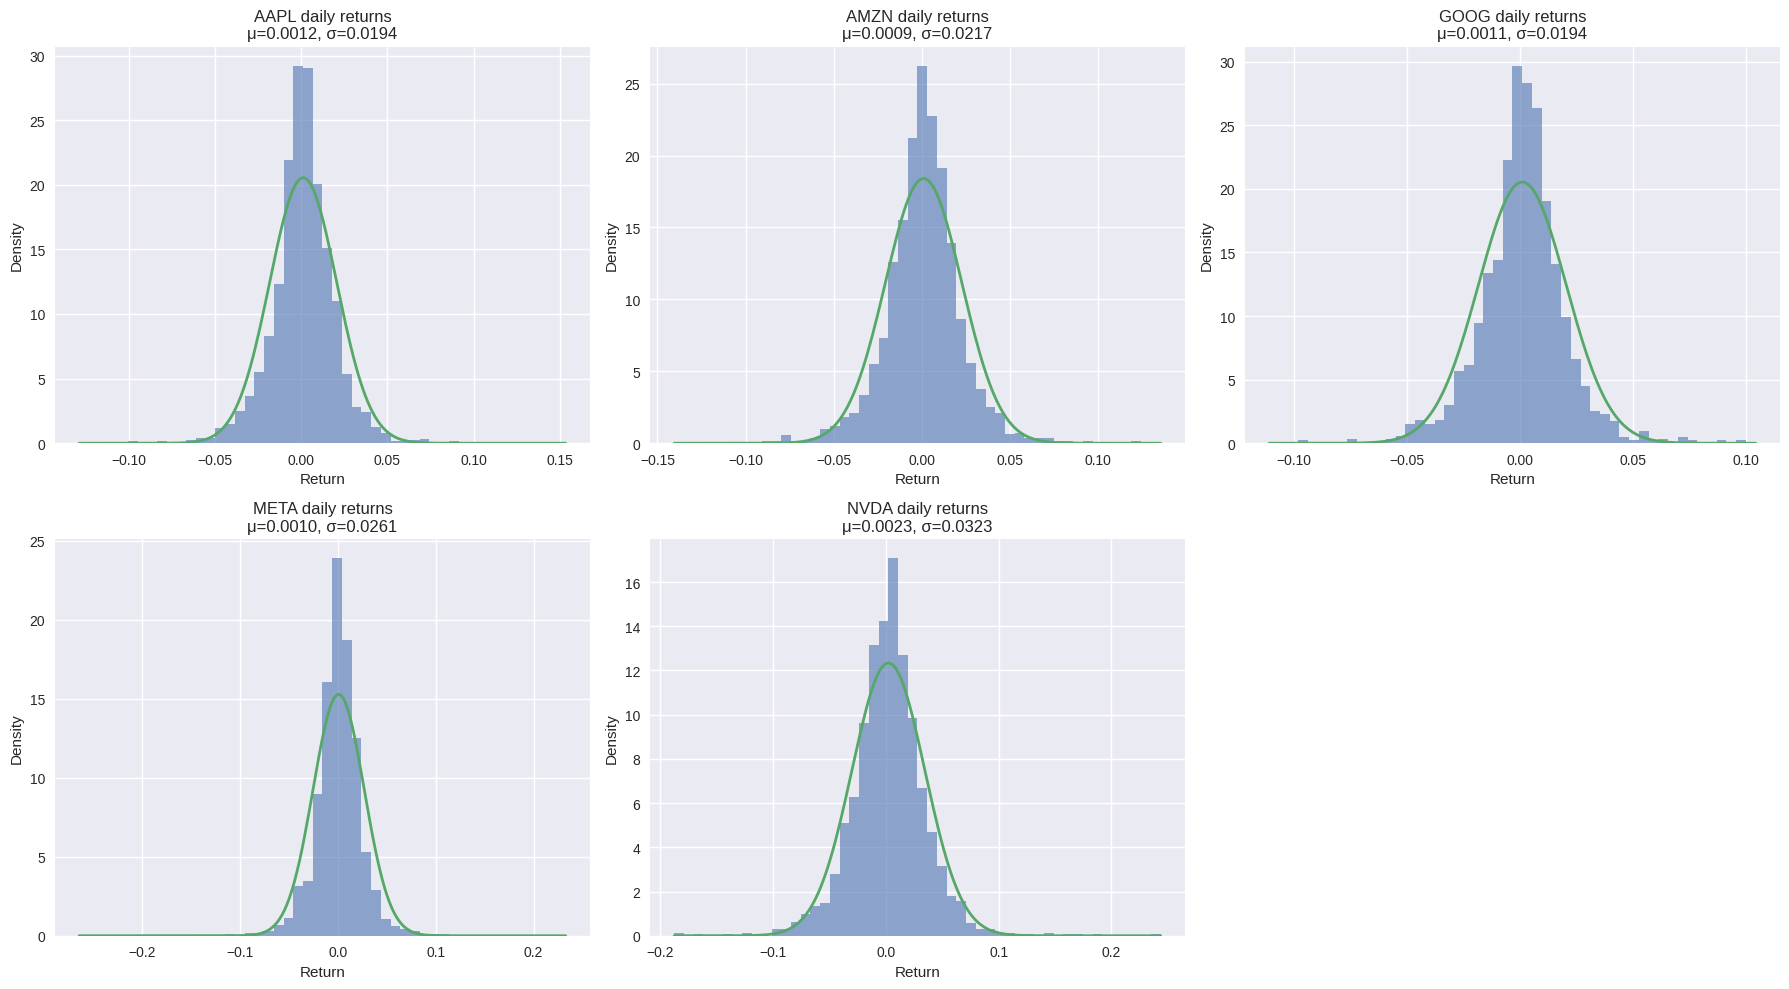

In [31]:
from scipy.stats import norm

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    r = returns[ticker].dropna()

    # Histogram
    n, bins, _ = ax.hist(r, bins=50, density=True, alpha=0.6)

    # Fit normal
    mu, sigma = r.mean(), r.std()
    x = np.linspace(r.min(), r.max(), 200)
    pdf = norm.pdf(x, mu, sigma)
    ax.plot(x, pdf, linewidth=2)

    ax.set_title(f"{ticker} daily returns\nμ={mu:.4f}, σ={sigma:.4f}")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")

# Hide any unused subplot
for j in range(len(TICKERS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [32]:
normality_results = []

for ticker in TICKERS:
    r = returns[ticker].dropna()

    skew = stats.skew(r)
    kurt = stats.kurtosis(r, fisher=True)  # 0 = normal
    jb_stat, jb_p = stats.jarque_bera(r)
    shapiro_stat, shapiro_p = stats.shapiro(r.sample(min(5000, len(r)), random_state=42))

    normality_results.append({
        "ticker": ticker,
        "skew": skew,
        "kurtosis_excess": kurt,
        "JB_stat": jb_stat,
        "JB_pvalue": jb_p,
        "Shapiro_stat": shapiro_stat,
        "Shapiro_pvalue": shapiro_p
    })

normality_df = pd.DataFrame(normality_results).set_index("ticker")
normality_df


,skew,kurtosis_excess,JB_stat,JB_pvalue,Shapiro_stat,Shapiro_pvalue
ticker,,,,,,
AAPL,0.151769,6.405117,3441.890879,0.000000e+00,0.934086,6.250437e-29
AMZN,0.095569,4.254816,1518.468808,0.000000e+00,0.953657,9.510885e-25
GOOG,0.001999,3.996227,1336.809447,5.194178e-291,0.950653,1.810427e-25
META,-0.330316,18.103258,27470.093584,0.000000e+00,0.864142,1.330733e-38
NVDA,0.132316,4.822190,1952.375367,0.000000e+00,0.957081,6.974010e-24


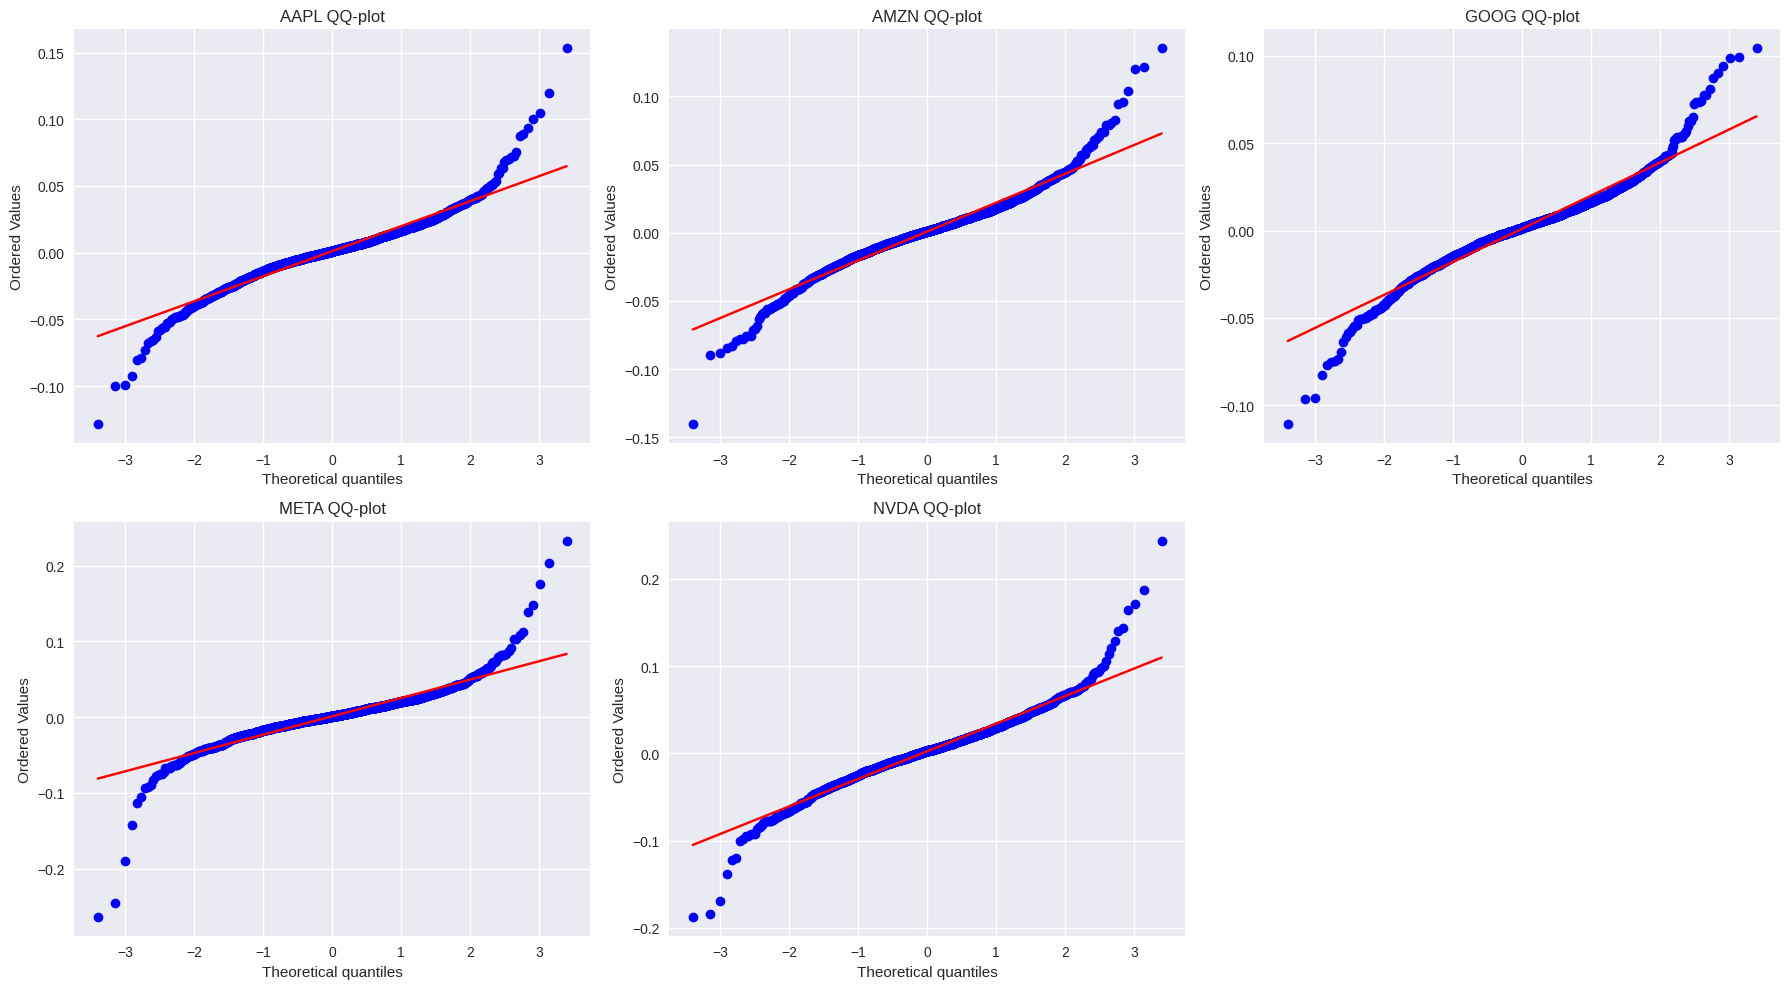

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    r = returns[ticker].dropna()
    stats.probplot(r, dist="norm", plot=ax)
    ax.set_title(f"{ticker} QQ-plot")

for j in range(len(TICKERS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Correlation matrix:


Ticker,AAPL,AMZN,GOOG,META,NVDA
Ticker,,,,,
AAPL,1.000000,0.595035,0.624948,0.534494,0.573043
AMZN,0.595035,1.000000,0.644941,0.612318,0.585678
GOOG,0.624948,0.644941,1.000000,0.612476,0.574957
META,0.534494,0.612318,0.612476,1.000000,0.526736
NVDA,0.573043,0.585678,0.574957,0.526736,1.000000


Covariance matrix:


Ticker,AAPL,AMZN,GOOG,META,NVDA
Ticker,,,,,
AAPL,0.000377,0.000250,0.000236,0.000271,0.000360
AMZN,0.000250,0.000470,0.000272,0.000346,0.000410
GOOG,0.000236,0.000272,0.000378,0.000311,0.000361
META,0.000271,0.000346,0.000311,0.000681,0.000445
NVDA,0.000360,0.000410,0.000361,0.000445,0.001045


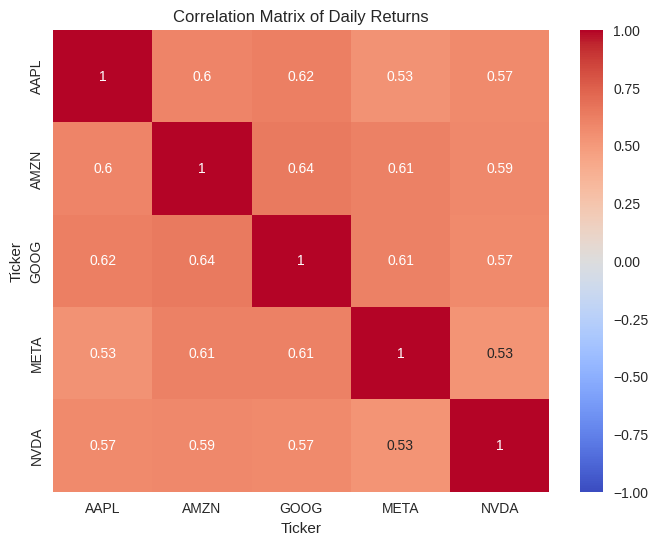

In [34]:
corr_matrix = returns.corr()
cov_matrix = returns.cov()

print("Correlation matrix:")
display(corr_matrix)

print("Covariance matrix:")
display(cov_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Returns")
plt.show()


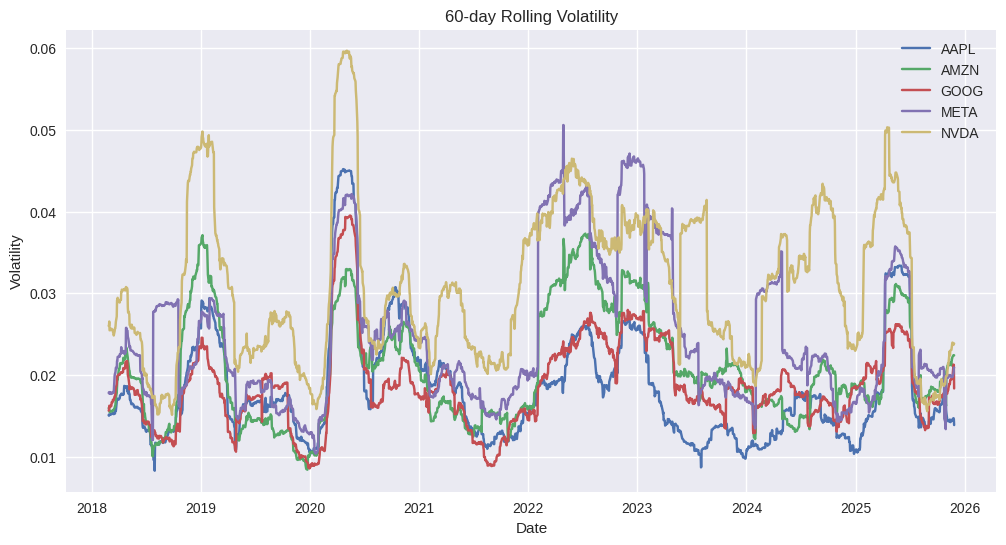

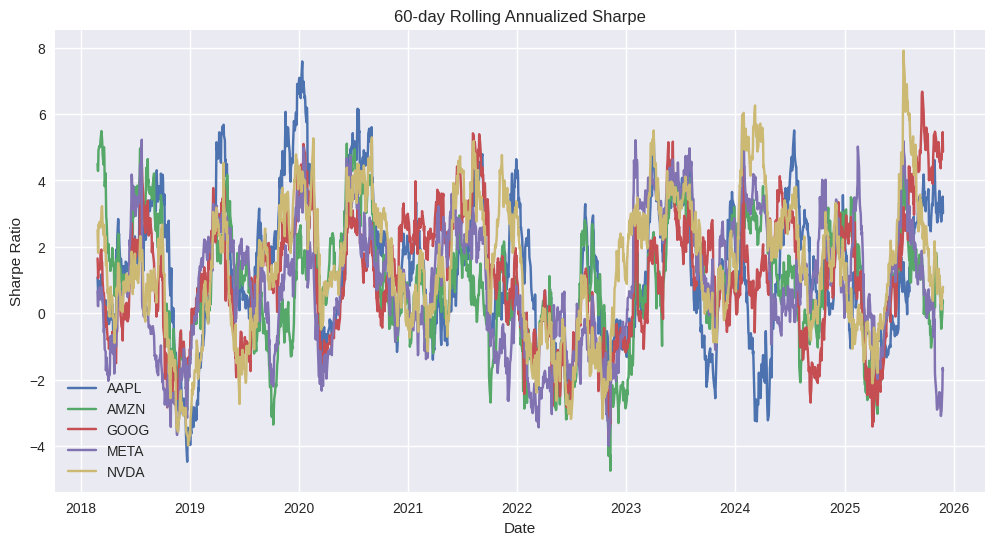

In [35]:
window = 60  # 60 trading days ~ 3 months

rolling_mean = returns.rolling(window).mean()
rolling_vol = returns.rolling(window).std()
rolling_sharpe = (rolling_mean / rolling_vol) * np.sqrt(TRADING_DAYS)

# Plot rolling volatility for each ticker
plt.figure(figsize=(12, 6))
for ticker in TICKERS:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker)
plt.title(f"{window}-day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Plot rolling Sharpe for each ticker
plt.figure(figsize=(12, 6))
for ticker in TICKERS:
    plt.plot(rolling_sharpe.index, rolling_sharpe[ticker], label=ticker)
plt.title(f"{window}-day Rolling Annualized Sharpe")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()


In [36]:
# Align stock returns and benchmark returns
combined = pd.concat([returns, benchmark_returns.rename(BENCHMARK)], axis=1).dropna()

excess_stock = combined[TICKERS]  # rf assumed ~ 0
excess_market = combined[BENCHMARK]

capm_results = []

for ticker in TICKERS:
    y = excess_stock[ticker]
    X = sm.add_constant(excess_market)
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params["const"], model.params[BENCHMARK]

    capm_results.append({
        "ticker": ticker,
        "alpha_daily": alpha,
        "beta": beta
    })

capm_df = pd.DataFrame(capm_results).set_index("ticker")
# Annualize alpha (approx)
capm_df["alpha_annual"] = capm_df["alpha_daily"] * TRADING_DAYS
capm_df


,alpha_daily,beta,alpha_annual
ticker,,,
AAPL,0.000285,1.049257,0.071833
AMZN,-0.000012,1.119550,-0.002972
GOOG,0.000268,1.009444,0.067478
META,-0.000021,1.214526,-0.005224
NVDA,0.000918,1.690402,0.231322


In [37]:
# Example: full summary for AAPL
y = excess_stock["AAPL"]
X = sm.add_constant(excess_market)
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     4076.
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:58:20   Log-Likelihood:                 6182.8
No. Observations:                2009   AIC:                        -1.236e+04
Df Residuals:                    2007   BIC:                        -1.235e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.144      0.253      -0.000       0.001
QQQ            1.0493      0.016     63.845      0.000       1.017       1.081
==============================================================================
Omnibus:                      302.277   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2446.995
Skew:                           0.452   Prob(JB):                         0.00
Kurtosis:                       8.330   Cond. No.                         66.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Equal weights
n_assets = len(TICKERS)
weights_eq = np.array([1/n_assets] * n_assets)

# Daily portfolio returns
pf_returns_eq = (returns[TICKERS] @ weights_eq)

# Daily portfolio stats
pf_mean_daily = pf_returns_eq.mean()
pf_std_daily = pf_returns_eq.std()
pf_mean_annual = pf_mean_daily * TRADING_DAYS
pf_std_annual = pf_std_daily * np.sqrt(TRADING_DAYS)
pf_sharpe_annual = pf_mean_annual / pf_std_annual

print("Equal-weight portfolio:")
print(f"Annualized Return: {pf_mean_annual:.4f}")
print(f"Annualized Volatility: {pf_std_annual:.4f}")
print(f"Annualized Sharpe: {pf_sharpe_annual:.4f}")


Equal-weight portfolio:
Annualized Return: 0.3272
Annualized Volatility: 0.3090
Annualized Sharpe: 1.0587


In [39]:
# Use annualized mean & covariance for portfolio calculations
mu_annual = mean_annual.values
cov_annual = (returns.cov() * TRADING_DAYS).values

def portfolio_stats(weights, mu, cov):
    """Return (ret, vol, sharpe) for given weights."""
    w = np.array(weights)
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    sharpe = (ret - RISK_FREE_ANNUAL) / vol
    return ret, vol, sharpe

# Monte Carlo simulation of random portfolios
n_portfolios = 20000
all_weights = []
pf_rets = []
pf_vols = []
pf_sharpes = []

for _ in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= w.sum()
    ret, vol, sharpe = portfolio_stats(w, mu_annual, cov_annual)
    all_weights.append(w)
    pf_rets.append(ret)
    pf_vols.append(vol)
    pf_sharpes.append(sharpe)

pf_rets = np.array(pf_rets)
pf_vols = np.array(pf_vols)
pf_sharpes = np.array(pf_sharpes)

# Optimization: Min variance & Max Sharpe
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0.0, 1.0) for _ in range(n_assets))

def min_variance(mu, cov):
    def objective(w):
        return portfolio_stats(w, mu, cov)[1]  # minimize vol
    res = minimize(objective, x0=np.full(n_assets, 1/n_assets),
                   bounds=bounds, constraints=constraints)
    return res.x

def max_sharpe(mu, cov, rf):
    def objective(w):
        return -portfolio_stats(w, mu, cov)[2]  # maximize sharpe
    res = minimize(objective, x0=np.full(n_assets, 1/n_assets),
                   bounds=bounds, constraints=constraints)
    return res.x

weights_min_var = min_variance(mu_annual, cov_annual)
weights_max_sharpe = max_sharpe(mu_annual, cov_annual, RISK_FREE_ANNUAL)

# Stats for special portfolios
ret_eq, vol_eq, sharpe_eq = portfolio_stats(weights_eq, mu_annual, cov_annual)
ret_min, vol_min, sharpe_min = portfolio_stats(weights_min_var, mu_annual, cov_annual)
ret_ms, vol_ms, sharpe_ms = portfolio_stats(weights_max_sharpe, mu_annual, cov_annual)

print("Min-Variance weights:", dict(zip(TICKERS, np.round(weights_min_var, 3))))
print("Max-Sharpe weights:", dict(zip(TICKERS, np.round(weights_max_sharpe, 3))))


Min-Variance weights: {'AAPL': np.float64(0.429), 'AMZN': np.float64(0.18), 'GOOG': np.float64(0.391), 'META': np.float64(0.0), 'NVDA': np.float64(0.0)}
Max-Sharpe weights: {'AAPL': np.float64(0.32), 'AMZN': np.float64(0.0), 'GOOG': np.float64(0.212), 'META': np.float64(0.0), 'NVDA': np.float64(0.468)}


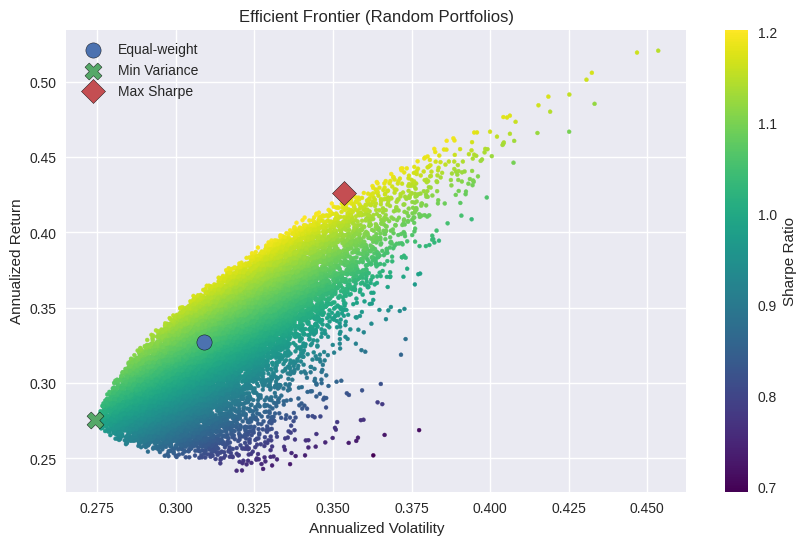

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(pf_vols, pf_rets, c=pf_sharpes, cmap="viridis", s=8)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (Random Portfolios)")

# Mark equal-weight, min-var, max-Sharpe
plt.scatter(vol_eq, ret_eq, marker="o", s=120, edgecolor="black", label="Equal-weight")
plt.scatter(vol_min, ret_min, marker="X", s=150, edgecolor="black", label="Min Variance")
plt.scatter(vol_ms, ret_ms, marker="D", s=150, edgecolor="black", label="Max Sharpe")

plt.legend()
plt.show()


In [41]:
from scipy.stats import norm

alpha = 0.95  # confidence level

# Daily stats
mu_p = pf_returns_eq.mean()
sigma_p = pf_returns_eq.std()

# Parametric (Gaussian) VaR (loss is positive)
z = norm.ppf(1 - alpha)  # this will be negative; we want loss
var_parametric = -(mu_p + z * sigma_p)  # VaR as a positive number

# Historical VaR
var_historical = -np.percentile(pf_returns_eq, (1 - alpha) * 100)

# CVaR (Expected Shortfall) - historical
threshold = np.percentile(pf_returns_eq, (1 - alpha) * 100)
cvar_historical = -pf_returns_eq[pf_returns_eq <= threshold].mean()

print(f"Parametric VaR (daily, {int(alpha*100)}%): {var_parametric:.4%}")
print(f"Historical VaR (daily, {int(alpha*100)}%): {var_historical:.4%}")
print(f"Historical CVaR (daily, {int(alpha*100)}%): {cvar_historical:.4%}")


Parametric VaR (daily, 95%): 3.0720%
Historical VaR (daily, 95%): 3.2213%
Historical CVaR (daily, 95%): 4.5590%


In [42]:
# Portfolio variance and std (annual)
cov_annual_matrix = returns.cov() * TRADING_DAYS
w = weights_eq.reshape(-1, 1)

portfolio_variance = float(w.T @ cov_annual_matrix.values @ w)  # scalar
portfolio_vol = np.sqrt(portfolio_variance)

# Marginal contribution to risk: ∂σ/∂w_i = (Σ w)_i / σ
sigma_w = cov_annual_matrix.values @ w
marginal_contrib = sigma_w.flatten() / portfolio_vol

# Risk contribution of each asset: w_i * MCTR_i
risk_contrib = weights_eq * marginal_contrib
risk_contrib_pct = risk_contrib / risk_contrib.sum()

risk_contrib_df = pd.DataFrame({
    "weight": weights_eq,
    "marginal_risk_contrib": marginal_contrib,
    "risk_contrib": risk_contrib,
    "risk_contrib_pct": risk_contrib_pct
}, index=TICKERS)

risk_contrib_df


/tmp/ipython-input-3549611507.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  portfolio_variance = float(w.T @ cov_annual_matrix.values @ w)  # scalar


,weight,marginal_risk_contrib,risk_contrib,risk_contrib_pct
AAPL,0.2,0.243584,0.048717,0.157653
AMZN,0.2,0.285163,0.057033,0.184564
GOOG,0.2,0.253894,0.050779,0.164326
META,0.2,0.335003,0.067001,0.216822
NVDA,0.2,0.427420,0.085484,0.276636
